# Grounded Segement Anthing

![gdgligen](https://github.com/IDEA-Research/Grounded-Segment-Anything/raw/main/assets/grounded_sam_inpainting_demo.png)

**Why this project?**
- [Segment Anything](https://github.com/facebookresearch/segment-anything) is a strong segmentation model. But it need prompts (like boxes/points) to generate masks. 
- [Grounding DINO](https://github.com/IDEA-Research/GroundingDINO) is a strong zero-shot detector which enable to generate high quality boxes and labels with free-form text. 
- The combination of the two models enable to **detect and segment everything** with text inputs!

# Prepare Environments

In [1]:
! python -m pip install -e segment_anything
! python -m pip install -e GroundingDINO
! pip install diffusers transformers accelerate scipy safetensors

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///C:/Users/j/gitlab/tierli_ahluege/Grounded-Segment-Anything/segment_anything
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: segment-anything
    Found existing installation: segment-anything 1.0
    Uninstalling segment-anything-1.0:
      Successfully uninstalled segment-anything-1.0
  Running setup.py develop for segment-anything



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///C:/Users/j/gitlab/tierli_ahluege/Grounded-Segment-Anything/GroundingDINO
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os, sys

sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))

In [3]:
# If you have multiple GPUs, you can set the GPU to use here.
# The default is to use the first GPU, which is usually GPU 0.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import argparse
import os
import copy
import pandas as pd
import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import annotate, load_image, predict

import supervision as sv

# segment anything
# from segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


# diffusers
import PIL
import requests
import torch
from io import BytesIO
from diffusers import StableDiffusionInpaintPipeline


from huggingface_hub import hf_hub_download

# Load Grounding DINO model

In [5]:
def load_model_hf(repo_id, filename, ckpt_config_filename, device='cpu'):
    cache_config_file = hf_hub_download(repo_id=repo_id, filename=ckpt_config_filename)

    args = SLConfig.fromfile(cache_config_file) 
    model = build_model(args)
    args.device = device

    cache_file = hf_hub_download(repo_id=repo_id, filename=filename)
    checkpoint = torch.load(cache_file, map_location='cpu')
    log = model.load_state_dict(clean_state_dict(checkpoint['model']), strict=False)
    print("Model loaded from {} \n => {}".format(cache_file, log))
    _ = model.eval()
    return model   

In [6]:
# Use this command for evaluate the Grounding DINO model
# Or you can download the model by yourself
ckpt_repo_id = "ShilongLiu/GroundingDINO"
ckpt_filenmae = "groundingdino_swinb_cogcoor.pth"
ckpt_config_filename = "GroundingDINO_SwinB.cfg.py"

In [7]:
groundingdino_model = load_model_hf(ckpt_repo_id, ckpt_filenmae, ckpt_config_filename)

c:\Users\j\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from C:\Users\j\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


# Load SAM model

In [15]:
! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

In [189]:
sam_checkpoint = 'sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

# Load demo image

In [8]:
import io


def download_image(url, image_file_path):
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    print('Image downloaded from url: {} and saved to: {}.'.format(url, image_file_path))

# download_image(image_url, local_image_path)

In [9]:
local_image_path = 'assets/inpaint_demo.jpg'
train_data = pd.read_csv("../competition_data/trainfeatures_megadet_bbox_split.csv")

In [10]:
train_data

,id,filepath,site,split,conf,bbox,bbox_normalized,bbox_true
0,ZJ000000,train_features/ZJ000000.jpg,S0120,2.0,0.690,"(322, 109, 92, 69)","[0.1093, 0.5888, 0.0802, 0.1851]",True
1,ZJ000001,train_features/ZJ000001.jpg,S0069,3.0,0.813,"(4, 542, 515, 120)","[0.5604, 0, 0.1333, 0.9685]",True
2,ZJ000002,train_features/ZJ000002.jpg,S0009,0.0,0.612,"(284, 330, 56, 74)","[0.5093, 0.7777, 0.1281, 0.1777]",True
3,ZJ000003,train_features/ZJ000003.jpg,S0008,4.0,0.686,"(230, 4, 107, 129)","[0, 0.6277, 0.214, 0.3194]",True
4,ZJ000004,train_features/ZJ000004.jpg,S0036,0.0,0.476,"(194, 326, 91, 66)","[0.5031, 0.5671, 0.1156, 0.2955]",True
...,...,...,...,...,...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093,1.0,NaN,NaN,NaN,False
16484,ZJ016484,train_features/ZJ016484.jpg,S0043,3.0,0.528,"(4, 399, 335, 237)","[0.6171, 0, 0.3828, 0.9527]",True
16485,ZJ016485,train_features/ZJ016485.jpg,S0089,3.0,0.151,"(291, 279, 49, 129)","[0.4296, 0.7972, 0.214, 0.1583]",True
16486,ZJ016486,train_features/ZJ016486.jpg,S0095,2.0,0.264,"(302, 124, 46, 85)","[0.125, 0.5518, 0.09687, 0.1]",True


# Run Grounding DINO for detection

In [34]:
def get_boxes_logits_phrases(image_path):
    TEXT_PROMPT = "animal.antelope.bird.genet.hog.leopard.monkey.rodent"
    BOX_TRESHOLD = 0.3
    TEXT_TRESHOLD = 0.25

    image_source, image = load_image(image_path)

    boxes, logits, phrases = predict(
        model=groundingdino_model, 
        image=image, 
        caption=TEXT_PROMPT, 
        box_threshold=BOX_TRESHOLD, 
        text_threshold=TEXT_TRESHOLD
    )

    annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
    annotated_frame = annotated_frame[...,::-1] # BGR to RGB
    return (np.array(boxes),np.array(logits),np.array(phrases)),annotated_frame

(array([], shape=(0, 4), dtype=float32), array([], dtype=float32), array([], dtype=float64))


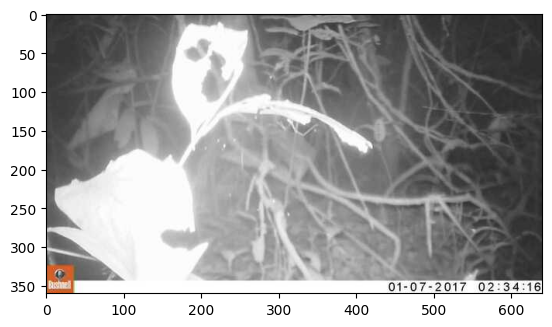

In [35]:
image_path = f"../competition_data/{train_data['filepath'][112]}"
boxes ,annotated_frame=get_boxes_logits_phrases(image_path)
print(boxes)
plt.imshow(annotated_frame)

In [8]:
all_boxes= []
#all_boxes = list(np.load("../competition_data/grounding_dino/grounding_dino_last_calc.npy",allow_pickle=True))
all_boxes = list(np.load("../competition_data/grounding_dino/grounding_dino14000.npy",allow_pickle=True))
for image_index in range(len(all_boxes),16488):
    if image_index % 100 == 0:
        print(image_index)
    if image_index % 1000 == 0:
        np.save(f"../competition_data/grounding_dino/grounding_dino{image_index}",np.array(all_boxes))
        pd.DataFrame({"grounding_dino":all_boxes}).to_csv(f"../competition_data/grounding_dino/grounding_dino{image_index}.csv")
    image_path = f"../competition_data/{train_data['filepath'][image_index]}"
    all_boxes.append(get_boxes_logits_phrases(image_path))

FileNotFoundError: [Errno 2] No such file or directory: '../competition_data/grounding_dino/grounding_dino14000.npy'

In [10]:
np.save("../competition_data/grounding_dino/train/grounding_dino_last_calc",np.array(np.array([[np.array(x) for x in y]for y in all_boxes])))

C:\Users\j\AppData\Local\Temp\ipykernel_17832\4245015621.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save("../competition_data/grounding_dino/grounding_dino_last_calc",np.array(np.array([[np.array(x) for x in y]for y in all_boxes])))


In [11]:
all_boxes= []
test_data = pd.read_csv("../competition_data/testfeatures_megadet_bbox.csv")
all_boxes = list(np.load("../competition_data/grounding_dino/test/grounding_dino_test3500.npy",allow_pickle=True))
for image_index in range(len(all_boxes),len(test_data)):
    if image_index % 100 == 0:
        print(image_index)
    if image_index % 500 == 0:
        np.save(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}",np.array(all_boxes))
        pd.DataFrame({"grounding_dino":all_boxes}).to_csv(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}.csv")
    image_path = f"../competition_data/{test_data['filepath'][image_index]}"
    all_boxes.append(get_boxes_logits_phrases(image_path))

3500


c:\Users\j\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\modeling_utils.py:866: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\Users\j\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\utils\checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


3600
3700
3800
3900
4000


C:\Users\j\AppData\Local\Temp\ipykernel_19372\357649272.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}",np.array(all_boxes))


4100
4200
4300
4400


In [12]:
np.save(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}",np.array(all_boxes))
pd.DataFrame({"grounding_dino":all_boxes}).to_csv(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}.csv")

C:\Users\j\AppData\Local\Temp\ipykernel_19372\295712897.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f"../competition_data/grounding_dino/test/grounding_dino_test{image_index}",np.array(all_boxes))


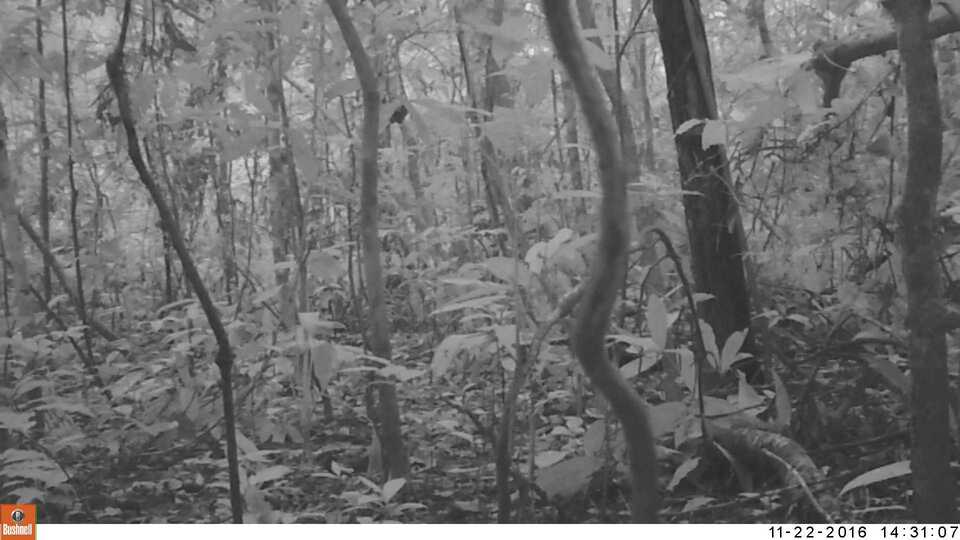

In [46]:
Image.fromarray(image_source)

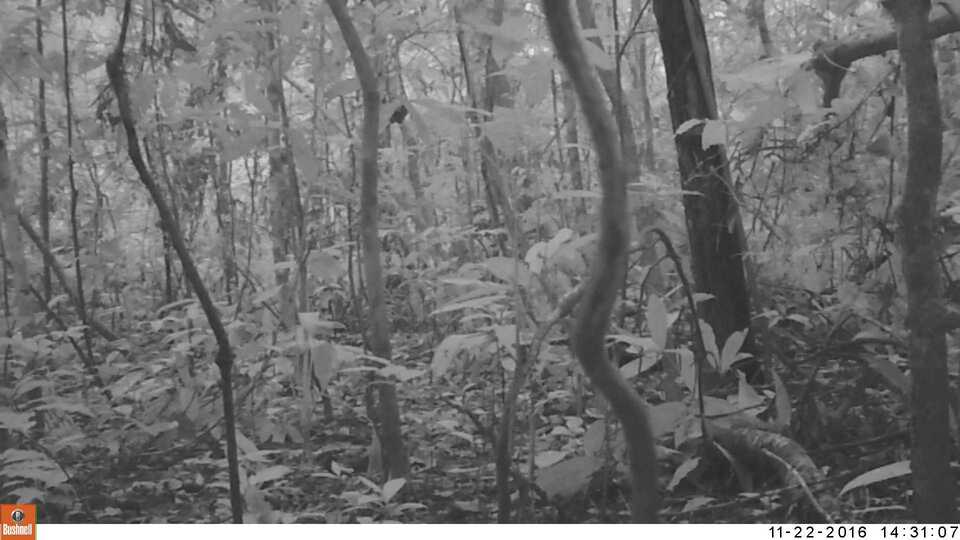

In [47]:
Image.fromarray(annotated_frame)

# Run the segmentation model

In [171]:
# set image
sam_predictor.set_image(image_source)

In [172]:
# box: normalized box xywh -> unnormalized xyxy
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [173]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )


In [174]:
def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [175]:
annotated_frame_with_mask = show_mask(masks[0][0], annotated_frame)

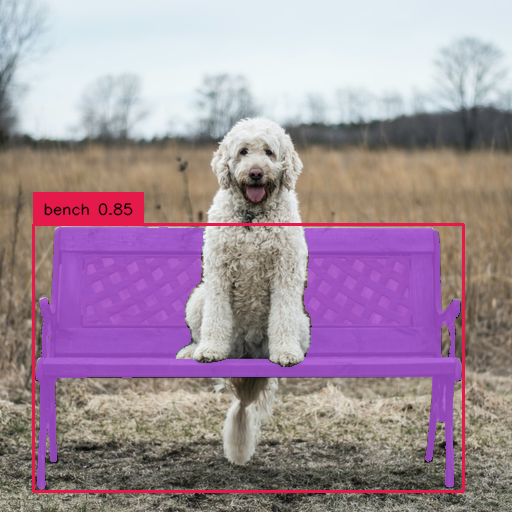

In [176]:
Image.fromarray(annotated_frame_with_mask)